# Integral Equation Model Comparisons
Purpose of this notebook is to EOS calculations for comparisons to George Petrov's Average Atom model, and Morales EOS Hydrogen paper

[https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


#### Load George Data

In [26]:
GP_H_file = "H-rho=1.dat"
GP_df = read_csv(GP_H_file, delim_whitespace=True, header=0)
GP_PMbar_1 = GP_df['P_ishikawa'][3:]
GP_PMbar_2 = GP_df['P_fauss'][3:]
GP_Te_eV = GP_df['Te'][3:]

#### Load Morales Data

In [27]:
Morales_file = "Morales_EOS_data.dat"
Morales_df = read_csv(Morales_file, delim_whitespace=True, header=4)
Morales_EAU  = Morales_df['E[AU]']
Morales_PGPa = Morales_df['P[GPa]']
Morales_TK   = Morales_df['T[K]']
Morales_PMbar =  1e-2*Morales_PGPa
Morales_TeV = Morales_TK/eV_to_K

### Set Parameters in Paper and Plot

In [3]:
name = 'Hydrogen'
Z, A = 1,1 

Te_eV_list = GP_Te_eV # eV
Ti_eV_list = Te_eV_list
ni_cc = 5.98e23

ri_cm = rs_from_n(ni_cc)  # cm
ri_AU = ri_cm*cm_to_AU    # AU 

In [4]:
ri_AU


1.3914542638521432

#### Run Ornstein-Zernike Closure

In [5]:
def plasma_output(plasma):
    plasma.run_hnc()
    Pe_hnc_id, Pe_hnc_ex   = plasma.hnc.rho[1]*plasma.hnc.Temp_list[1],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[1] 
    Pe_Mbar_id, Pe_Mbar_ex = P_hnc_to_Mbar(Pe_hnc_id), P_hnc_to_Mbar(Pe_hnc_ex)
    Pe_Mbar = Pe_Mbar_id + Pe_Mbar_ex
    return Pe_Mbar_id, Pe_Mbar_ex, Pe_Mbar

name1 = 'OZ - g'
plasma1 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name2 = 'OZ - th'
plasma2 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name3 = 'OZ - g  Pauli'
plasma3 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name4 = 'SVT - th'
plasma4 =  lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'svt'},
                 hnc_solve_options={'alpha_Picard':0.5,'num_iterations':1e4})

P_hnc_to_bar = lambda P_hnc: (P_hnc/ri_AU**3) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc: 1e-6*P_hnc_to_bar(P_hnc)
P_hnc_to_GPa = lambda P_hnc:  P_hnc_to_bar(P_hnc) * 1e5 / 1e9 

####  Investigate Pressure 

In [10]:
# print("P = {0:.3e} [Mbar]".format(P_hnc_to_Mbar(Pid)))
# print("P = {0:.3e} [GPa]".format(P_hnc_to_GPa(Pid)))

### Compute all plasma models for list of densities

In [7]:
P_list_1 = []
P_list_2 = []
P_list_3 = []
P_list_4 = []

for T_eV in Te_eV_list:
    #1
    plasma = plasma1(T_eV)
    Pe_id, Pe_ex, Pe = plasma_output(plasma)
    P_list_1.append( [Pe_id, Pe_ex, Pe] )
    #2
    plasma = plasma2(T_eV)
    Pe_id, Pe_ex, Pe = plasma_output(plasma)
    P_list_2.append( [Pe_id, Pe_ex, Pe] )
    #3
    plasma = plasma3(T_eV)
    Pe_id, Pe_ex, Pe = plasma_output(plasma)
    P_list_3.append( [Pe_id, Pe_ex, Pe] )
    #4
    plasma = plasma4(T_eV)
    Pe_id, Pe_ex, Pe = plasma_output(plasma)
    P_list_4.append( [Pe_id, Pe_ex, Pe] )
    

Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 3.080e+00
Exiting status 0, reverting to best index so far: 186
Final iter:187, Total Error: 9.452e-09
Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 3.066e+00
Exiting status 0, reverting to best index so far: 189
Final iter:190, Total Error: 9.987e-09
Te_in_eV: 1.000
Ti_in_eV: 1.000


/home/zach/plasma/hnc/hnc/PIE.py:144: RuntimeWarning: overflow encountered in exp
  κ = 3*(2*T*m_e) / (self.qsp.k_F**3 * r)  * np.sum(dt* t*np.sin(sin_arg*t) /(1+np.exp(t**2-η) )  )


0: Initial condition Total Error: 3.080e+00
Exiting status 0, reverting to best index so far: 190
Final iter:191, Total Error: 9.210e-09
Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 3.063e+00
Exiting status 0, reverting to best index so far: 153
Final iter:154, Total Error: 9.115e-09
Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 1.810e+00
Exiting status 0, reverting to best index so far: 110
Final iter:111, Total Error: 9.715e-09
Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 1.797e+00
Exiting status 0, reverting to best index so far: 114
Final iter:115, Total Error: 9.350e-09
Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 1.810e+00
Exiting status 0, reverting to best index so far: 105
Final iter:106, Total Error: 8.480e-09
Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 1.794e+00
Exiting status 0, reverting to best index so far: 93
Final iter:94, Total Error: 9.707e-09
Te_in_eV: 5.000
Ti_i

Now Plot 

In [8]:
P_list_1 = np.array(P_list_1)
P_list_2 = np.array(P_list_2)
P_list_3 = np.array(P_list_3)
P_list_4 = np.array(P_list_4)

In [25]:
Morales_TeV

0    0.172347
1    0.172347
2    0.172347
3    0.172347
4    0.172347
5    0.172347
Name: T[K], dtype: float64

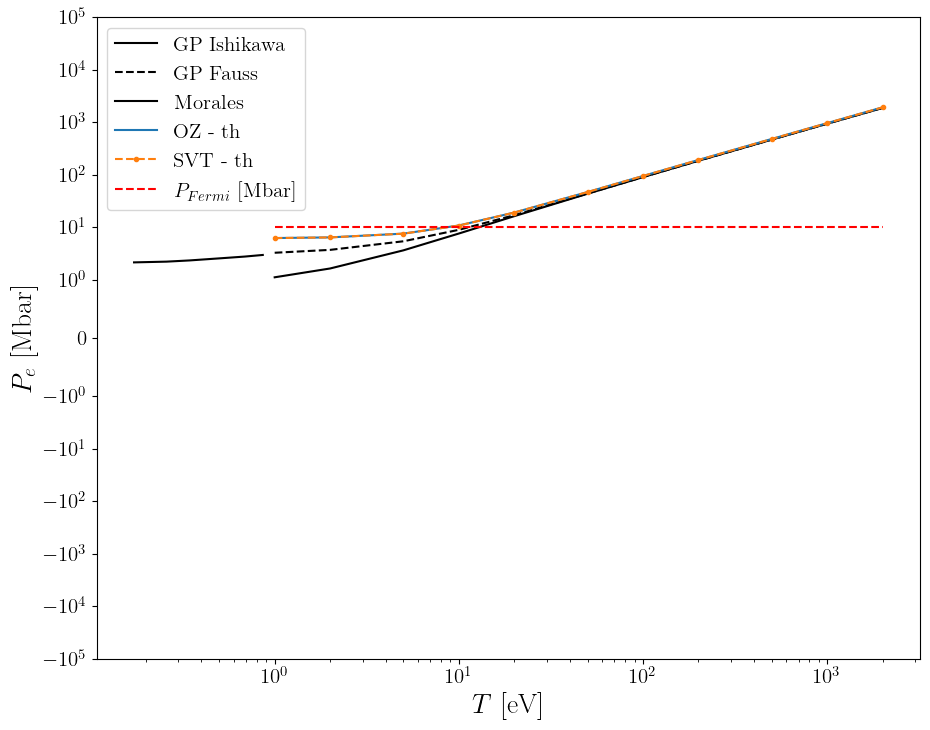

In [30]:
fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot GP data 
axs[0].plot(GP_Te_eV, GP_PMbar_1, 'k-', label='GP Ishikawa')
axs[0].plot(GP_Te_eV, GP_PMbar_2, 'k--', label='GP Fauss')

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar, 'k-', label='Morales')

# Plot Pressure ratio
# axs[0].plot(GP_Te_eV, P_list_1[:,2], label=name1)
axs[0].plot(Te_eV_list, P_list_2[:,2], label=name2)
# axs[0].plot(Te_eV_list, P_list_3[:,2], label=name3)
axs[0].plot(Te_eV_list, P_list_4[:,2],'--.', label=name4)

# Plot Fermi Pressure
P_Fermi_Mbar = 2/5 * plasma.qsp.E_F/(4/3*π*(plasma.qsp.ri)**3) * AU_to_bar/1e6
axs[0].plot(GP_Te_eV, GP_Te_eV*0 +P_Fermi_Mbar,'r--', label=r"$P_{Fermi}$ [Mbar]"  )

for ax in axs:
    ax.legend(fontsize=15, loc='upper left')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    ax.set_ylim(-1e5, 1e5)
    ax.set_ylabel(r"$P_e$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()